<a href="https://colab.research.google.com/github/pumpzcc/EvolutionaryDeepLearning/blob/main/EDL_9_1_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install livelossplot --quiet

In [2]:
#@title The Imports
from tensorflow.keras.datasets import mnist as data
#from tensorflow.keras.datasets import fashion_mnist as data

#from tensorflow.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Reshape, Dropout, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Convolution2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop

import numpy as np
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from tqdm import tqdm_notebook

import random
from tqdm.notebook import tqdm as tqdm

In [3]:
#@title Load and Normalize Training/Test Data
(train_images, train_labels), (test_images, test_labels) = data.load_data()

# Scale Dataset -1 to +1
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 127.5 - 1

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
#@title Extract Class of Images
def extract(images, labels, class_):
  idx = labels == class_
  print(idx)
  imgs = images[idx]
  print(imgs.shape)
  return imgs

train_images = extract(train_images, train_labels, 5)

[ True False False ...  True False False]
(5421, 28, 28, 1)


In [5]:
#@title Internal Hyperparameters and Optimizers Setup
latent_dim = 100

g_optimizer = Adam(0.0002, 0.5)
d_optimizer = RMSprop(.00001)

In [6]:
#@title Determine Base Convolution Size
cs = int(train_images.shape[1] / 4)
print(train_images.shape)
channels = train_images.shape[3]
img_shape = (train_images.shape[1], train_images.shape[2], channels)

(5421, 28, 28, 1)


In [7]:
#@title Building the Generator (g)
def build_generator():
  model = Sequential()

  model.add(Dense(128 * cs * cs, activation="relu", input_dim=latent_dim))
  model.add(Reshape((cs, cs, 128)))
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size=3, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))
  model.add(UpSampling2D())
  model.add(Conv2D(64, kernel_size=3, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))
  model.add(Conv2D(channels, kernel_size=3, padding="same"))
  model.add(Activation("tanh"))

  model.summary(line_length = 100)

  noise = Input(shape=(latent_dim,))
  img = model(noise)
  return Model(noise, img)
g = build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                              │ (None, 6272)                    │           633,472 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ reshape (Reshape)                          │ (None, 7, 7, 128)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ up_sampling2d (UpSampling2D)               │ (None, 14, 14, 128)             │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d (Conv2D)                            │ (None, 14, 14, 128)             │           147,584 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization (BatchNormalization)   │ (None, 14, 14, 128)             │               512 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ activation (Activation)                    │ (None, 14, 14, 128)             │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ up_sampling2d_1 (UpSampling2D)             │ (None, 28, 28, 128)             │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_1 (Conv2D)                          │ (None, 28, 28, 64)              │            73,792 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_1 (BatchNormalization) │ (None, 28, 28, 64)              │               256 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ activation_1 (Activation)                  │ (None, 28, 28, 64)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_2 (Conv2D)                          │ (None, 28, 28, 1)               │               577 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ activation_2 (Activation)                  │ (None, 28, 28, 1)               │                 0 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 856,193 (3.27 MB)

 Trainable params: 855,809 (3.26 MB)

 Non-trainable params: 384 (1.50 KB)

In [8]:
#@title Building the Discriminator (d)
def build_discriminator():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  model.summary()

  img = Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

d = build_discriminator()
d.compile(loss='binary_crossentropy',
            optimizer=d_optimizer,
            metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393,729 (1.50 MB)

 Trainable params: 392,833 (1.50 MB)

 Non-trainable params: 896 (3.50 KB)

In [9]:
#@title Building the GAN
z = Input(shape=(latent_dim,))
img = g(z)

# For the combined model we will only train the generator
d.trainable = False

# The discriminator takes generated images as input and determines validity
valid = d(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
gan = Model(z, valid)
gan.compile(loss='binary_crossentropy', optimizer=g_optimizer)

In [10]:
#@title Plot Helper Functions
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, latent_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, img_shape[0], img_shape[1])

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow((1-generated_images[i])*255, interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

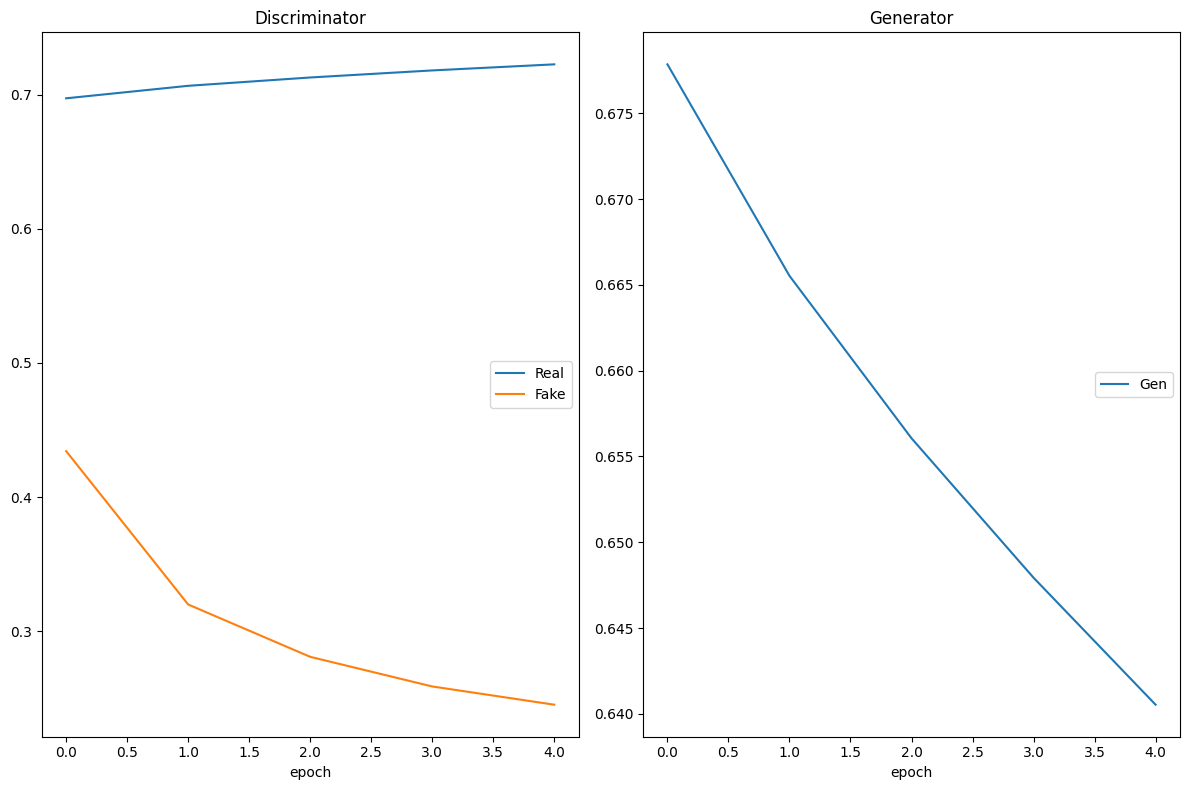

Discriminator
	Real             	 (min:    0.697, max:    0.723, cur:    0.723)
	Fake             	 (min:    0.245, max:    0.434, cur:    0.245)
Generator
	Gen              	 (min:    0.641, max:    0.678, cur:    0.641)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


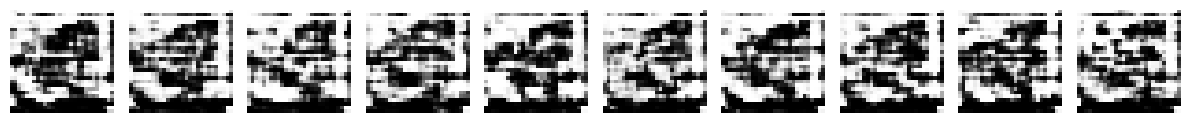

  0%|          | 0/21 [00:00<?, ?it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


In [ ]:
#@title Training the GAN
EPOCHS = 10 #@param {type:"slider", min:5, max:100, step:1}
BATCH_SIZE = 256 #@param {type:"slider", min:64, max:256, step:2}

groups = { "Discriminator" : {"Real", "Fake"}, "Generator":{"Gen"}}
plotlosses = PlotLosses(groups=groups)

batches = int(train_images.shape[0] / BATCH_SIZE)

# Adversarial ground truths
valid = np.ones((BATCH_SIZE, 1))
fake = np.zeros((BATCH_SIZE, 1))

for e in range(EPOCHS):
  for i in tqdm(range(batches)):
    # ---------------------
    #  Train Discriminator
    # ---------------------
    # Select a random half of images
    idx = np.random.randint(0, train_images.shape[0], BATCH_SIZE)
    imgs = train_images[idx]

    # Sample noise and generate a batch of new images
    noise = np.random.normal(0, 1, (BATCH_SIZE, latent_dim))
    gen_imgs = g.predict(noise)

    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = d.train_on_batch(imgs, valid)
    d_loss_fake = d.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------
    # Train the generator (wants discriminator to mistake images as real)
    g_loss = gan.train_on_batch(noise, valid)

  loss = dict(Real = d_loss[0], Fake = d_loss[1], Gen = g_loss)
  plotlosses.update(loss)
  plotlosses.send()
  plot_generated()
